In [4]:
# import MODULES
import numpy as np
import matplotlib.pyplot as plt
import xarray as xray
from glob import glob
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import cartopy.crs as ccrs
from matplotlib.cm import get_cmap
from datetime import datetime
from netCDF4 import Dataset,MFDataset
#from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim, ALL_TIMES, geo_bounds
import cmaps
import matplotlib.patches as mpatches
#import scipy.stats as st
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.ticker as mticker
#import wrf
import sys
#wrf.omp_enabled()
import pandas as pd
import matplotlib
#import seaborn as sns
#sns.set_style('whitegrid')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings("ignore")

In [5]:
def spatial_plot(ax,lat,lon,dat,cart,ran,cmpi,title):
    
    resol_N = [[75,90],[23,30],['1971-1-1','2010-12-31'],'N_box']
    resol_S = [[73,81],[14,22],['1971-1-1','2010-12-31'],'S_box']
    plotpath = '/home/kaushik/Desktop/plots_spatial/'
    
    # Mollweide
    dmin=ran[0]
    dmax = ran[-1]
    #    dmin=-1*np.max([np.abs(np.percentile(dat,1)),np.percentile(dat,99)])
    #    dmax=np.max([np.abs(np.percentile(dat,1)),np.percentile(dat,99)])
    print([dmin,dmax])
    pmesh = ax.pcolormesh(lon,lat,dat,vmin=dmin,vmax=dmax,transform=ccrs.PlateCarree(),cmap=cmpi)
    #pmesh = ax.contourf(lon,lat,dat,np.linspace(dmin,dmax,18),transform=ccrs.PlateCarree(),cmap=cmpi,extend = 'both')
    #pmesh = ax.pcolormesh(lon,lat,dat,transform=ccrs.PlateCarree(),cmap=cmpi)
    ax.coastlines(resolution='10m')
    #ax.add_patch(mpatches.Rectangle(xy=[resol_N[0][0], resol_N[1][0]], width=resol_N[0][1]-resol_N[0][0], height=resol_N[1][1]-resol_N[1][0],facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
    #ax.add_patch(mpatches.Rectangle(xy=[resol_S[0][0], resol_S[1][0]], width=resol_S[0][1]-resol_S[0][0], height=resol_S[1][1]-resol_S[1][0],facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
    fname = '/mnt/nas/DATA/kaushik/scripts/Python/India_shapefiles/India.shp'
    shape_feature = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor='none',edgecolor='black')
    ax.add_feature(shape_feature)
    plt.title(title)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    #gl.xlines = False
    gl.xlocator = mticker.FixedLocator([45,60,75,90,105,120])
    gl.ylocator = mticker.FixedLocator([-25,-10, 5, 20, 35,50])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    #plt.savefig(plotpath+title+'_JA_diff.png',bbox_inches='tight',dpi=300)
    #plt.clf()
    #plt.close('all')
    return ax,pmesh,gl

In [6]:
import geopandas as gpd
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='lat', longitude='lon',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xray.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = add_shape_coord_from_data_array(precip_da, "awash.shp", "awash")
        awash_da = precip_da.where(precip_da.awash==0, other=np.nan)
    """
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords,
                               longitude='lon', latitude='lat')

    return xr_da


def reg_sel():
    # Region Def.
    resol = {}
    resol['R1'] = [[72.5,81],[33,38]]
    #resol['R2'] = [[75,81,81,88,88,75],[33,33,28,28,24,24]]
    resol['R2'] = [[75,88],[24,33]]
    resol['R3'] = [[88,98],[22,30]]
    resol['R4'] = [[68,75],[22,30]]
    resol['R5'] = [[75,88],[17,24]]
    resol['R6'] = [[72,81],[8,17]]
    resol['ind'] = [[65,95],[5,45]]

    resol['IGP'] = [[75,83],[23,28]]#,['1971-1-1','2010-12-31'],'N_box']
    resol['EI'] = [[85,90],[20,25]]
    resol['S'] = [[73,81],[14,22]]
    resol['D'] = [[67+2,73+2],[23-2,30-2]]
    return resol



In [7]:
import scipy.stats as st
import pandas as pd
from collections import OrderedDict


def calc_PCC(WRF, OBS):
    return np.round(st.pearsonr(WRF,OBS)[0],2)
def calc_RMSE(WRF, OBS):
    return np.round(np.sqrt(((WRF - OBS)**2).mean()).data,2)
def calc_NMSE(WRF, OBS):
    return np.round((((WRF - OBS)**2).mean()/(WRF.mean() * OBS.mean())).data *100,1)
def calc_NMB(WRF, OBS):
    return np.round(((WRF - OBS).sum()/OBS.sum()).data*100,2)
def func_tp(tperiod):
    tslice = {}
    tslice['seas_std'] = ['MAM','DJF','JJA','SON']
    tslice['seas'] = ['JJAS','ON']
    tslice['Annual'] = ['Annual']
    tslice['months'] = list(np.linspace(1,12,12))
    for j in tslice.items():
        if tperiod in j[1]:
            tslice = j[0]
        else:
            print('')
    return tslice                

def regionX(dset,reg):
    resol = reg_sel()
    data = dset.sel(lat=slice(resol[reg][1][0], resol[reg][1][1]),lon=slice(resol[reg][0][0], resol[reg][0][1]))
    return data
def timeX(dset,tperiod):
    ts = func_tp(tperiod)
    if ts == 'seas_std':
        data = dset.sel(time = dset['time.season'] == tperiod)
    elif ts == 'Annual':
        data = dset.sel(time = dset['time.year'] == 2015)
    elif ts == 'months':
        data = dset.sel(time = dset['time.month'] == tperiod)
    elif (ts == 'seas') & (tperiod == 'JJAS'):
        data = dset.sel(time = (dset['time.month']>=6) & (dset['time.month']<=9))
    elif (ts == 'seas') & (tperiod == 'ON'):
        data = dset.sel(time = (dset['time.month']>=10) & (dset['time.month']<=11))
    else:
        print('invalid time period')
    return data
def indshp(dset):
    add_shape_coord_from_data_array(dset, '/mnt/nas/DATA/kaushik/scripts/Python/India_shapefiles/India.shp', 'ind')
    data = dset.where(dset.ind==0)
    return data
def tsX(dset,region='R1',tperiod='MAM'):
    data = timeX(indshp(regionX(dset,region)),tperiod)
    data = data.mean(['lat','lon']).resample(time='1D').mean()
    return data

def calc_stats(model_dset,obs_dset,region='R3',tperiod='MAM',obs_name='MODIS',scale=1):
    STATS = {}
    WRF = tsX(model_dset,region,tperiod)*scale
    OBS = tsX(obs_dset,region,tperiod)
    
    #STATS['PCC'] = calc_PCC(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['NMB'] = calc_NMB(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['RMSE'] = calc_RMSE(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['NMSE'] = calc_NMSE(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['O'] = np.round(OBS[np.isfinite(OBS)].mean().data,3)
    STATS['M'] = np.round(WRF[np.isfinite(OBS)].mean().data,3)
    return STATS

In [8]:
ranspec= {} 
ranspec['pr']=[0,40]
ranspec['rsds'] = [0,400]
ranspec['zmla'] = [200,1200]

def ext_WRF(vname,dmap):
    dset_WRF = []
    for fl in dmap:
        REL_PATH = '/mnt/nas/DATA/kaushik/proc/'+fl+'/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/'+'1hr'+'/'+vname+'/gn/'
        flist = sorted(glob(REL_PATH+'*2015*'))
        print(flist,'END')
        dset_base = xray.concat([xray.open_dataset(f)[vname] for f in flist],'time')
        dset_WRF.append(dset_base)

    dset_WRF = xray.concat(dset_WRF,pd.Index(dmap,name='exp'))
    return dset_WRF
def ext_OBS():
    dset_OBS = {}
    
    LWC_path = '/mnt/nas/DATA/Common/Observations/cloud/MODIS_LWC/AQUA/'
    LWC_prefix = 'scrubbed.MYD08_D3_6_1_Cloud_Water_Path_Liquid_Mean.'
    LWC_suffix = '.nc'

    #LWC_AQUA_dset = xray.open_mfdataset(glob(LWC_path+LWC_prefix+'*'+LWC_suffix),combine='by_coords')['MYD08_D3_6_1_Cloud_Water_Path_Liquid_Mean']
    LWC_AQUA_dset = xray.concat([xray.open_dataset(f) for f in glob(LWC_path+LWC_prefix+'*'+LWC_suffix)],dim='time')['MYD08_D3_6_1_Cloud_Water_Path_Liquid_Mean']
    LWC_AQUA_dset = LWC_AQUA_dset.sel(time = LWC_AQUA_dset['time.year']==2015)
    dset_OBS['MODIS-LWC'] = LWC_AQUA_dset
    
    ISCCP_path = '/mnt/nas/DATA/Common/Observations/cloud/ISCCP/'
    ISCCP_prefix = 'MapLowMidHigh330m_201?'
    ISCCP_suffix = '_avg_CFMIP1_sat_3.1.2.nc'
    
    CLL_dset = xray.concat([xray.open_dataset(f) for f in sorted(glob(ISCCP_path+ISCCP_prefix+'??'+ISCCP_suffix))],dim='time')['cllcalipso']
    CLL_dset = CLL_dset.rename({'longitude': 'lon','latitude': 'lat'})
    dset_OBS['ISCCP-CLL'] = CLL_dset
    
    CLM_dset = xray.concat([xray.open_dataset(f) for f in sorted(glob(ISCCP_path+ISCCP_prefix+'??'+ISCCP_suffix))],dim='time')['clmcalipso']
    CLM_dset = CLM_dset.rename({'longitude': 'lon','latitude': 'lat'})
    dset_OBS['ISCCP-CLM'] = CLM_dset
    
    CLH_dset = xray.concat([xray.open_dataset(f) for f in sorted(glob(ISCCP_path+ISCCP_prefix+'??'+ISCCP_suffix))],dim='time')['clhcalipso']
    CLH_dset = CLH_dset.rename({'longitude': 'lon','latitude': 'lat'})
    dset_OBS['ISCCP-CLH'] = CLH_dset
    
    
    CTT_path = '/mnt/nas/DATA/Common/Observations/cloud/MODIS_CTT/AQUA/'
    CTT_prefix = 'scrubbed.MYD08_D3_6_1_Cloud_Top_Temperature_Day_Mean.'
    CTT_suffix = '.nc'
    CTT_AQUA_dset = xray.concat([xray.open_dataset(f) for f in glob(CTT_path+CTT_prefix+'*'+CTT_suffix)],dim='time')['MYD08_D3_6_1_Cloud_Top_Temperature_Day_Mean']
    CTT_AQUA_dset = CTT_AQUA_dset.sel(time = CTT_AQUA_dset['time.year']==2015)
    dset_OBS['MODIS-CTT'] = CTT_AQUA_dset-273

    return dset_OBS



In [9]:
vname_m = 'clm'
vname_o = 'ISCCP-CLM'
scale = 1
dmap = ['processed','oWRF']

dset_WRF = ext_WRF(vname_m,dmap)
dset_OBS = (ext_OBS()[vname_o])

['/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/clm/gn/clm_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501010100-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/clm/gn/clm_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/clm/gn/clm_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/clm/gn/clm_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504010100-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/clm/gn/clm_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100-201506010000.nc'] END
['/mnt/nas/DATA/kaushik/p

DJF






[0, 0.3]
[0, 0.3]
[0, 0.3]
[-0.3, 0.3]
[-0.3, 0.3]
MAM






[0, 0.3]
[0, 0.3]
[0, 0.3]
[-0.3, 0.3]
[-0.3, 0.3]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


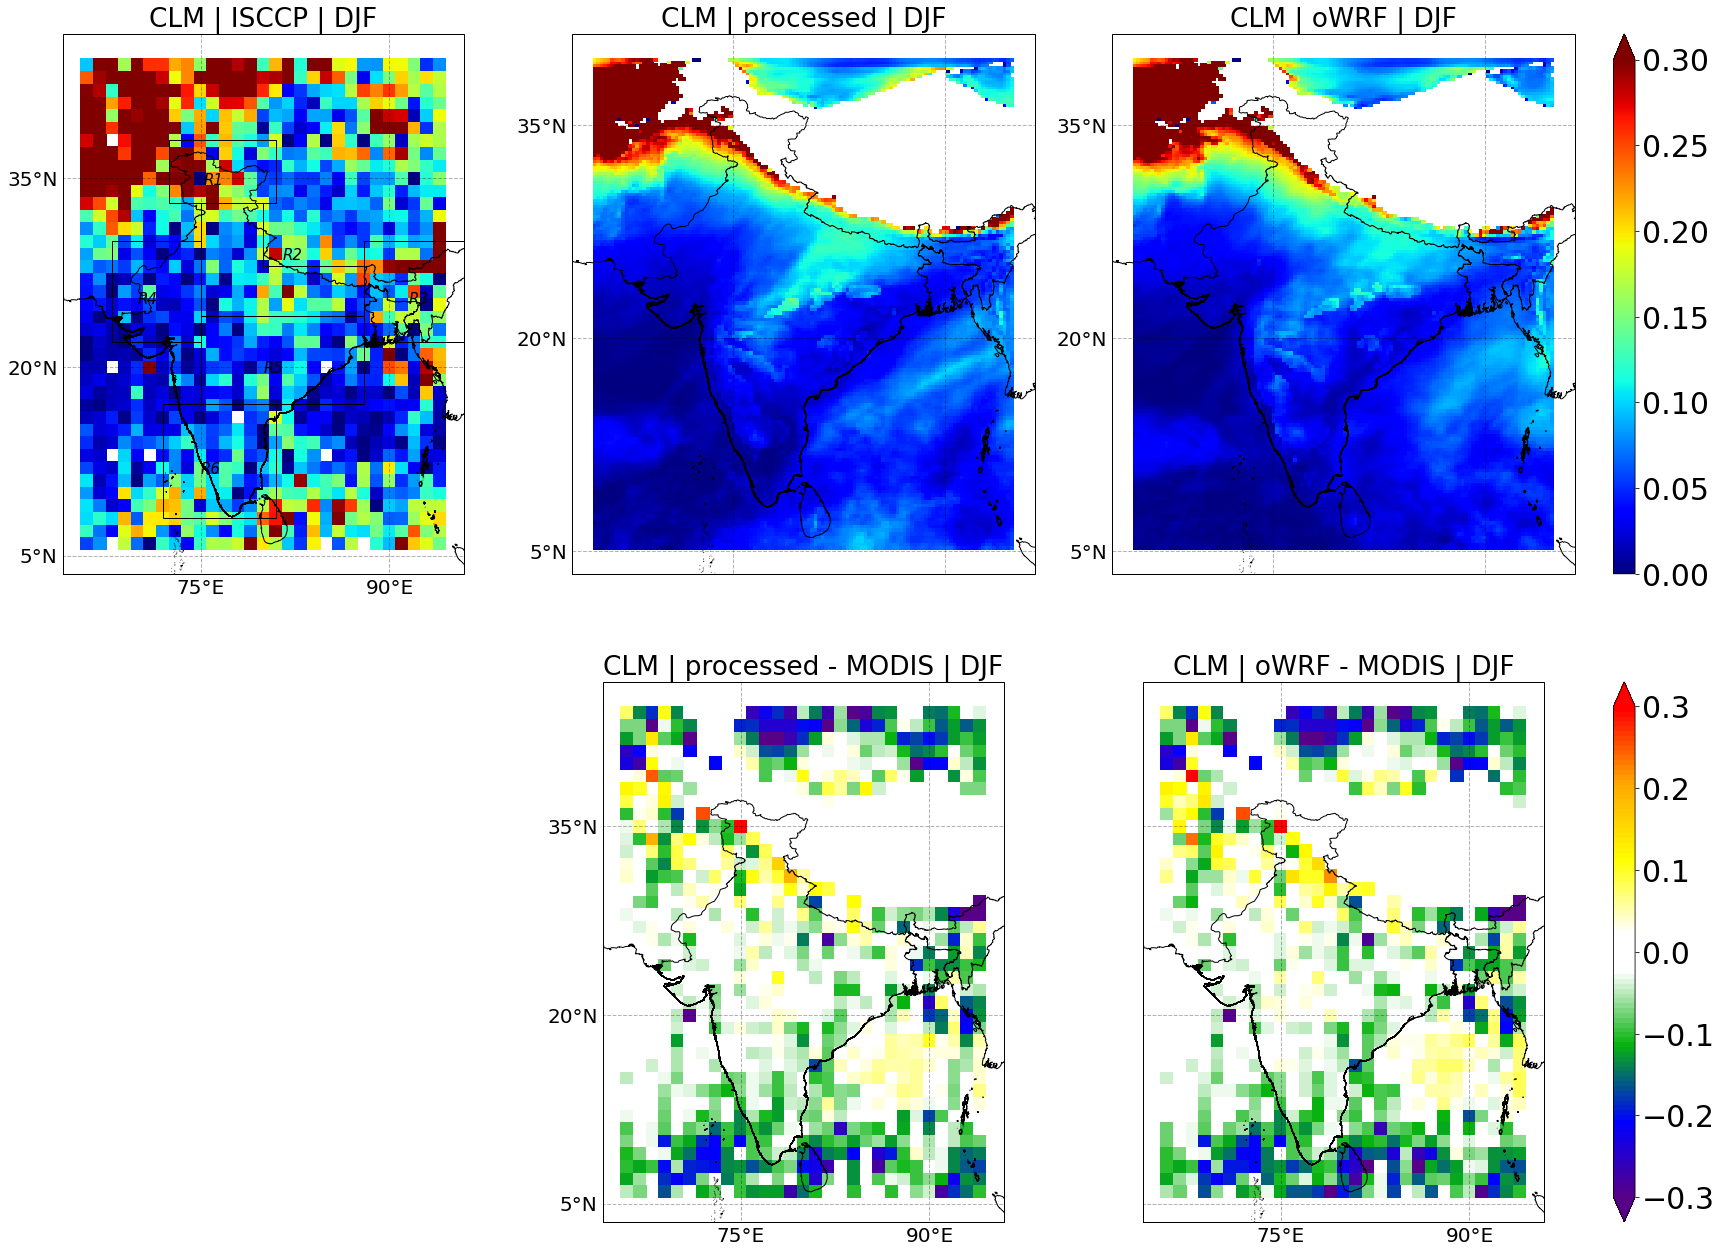

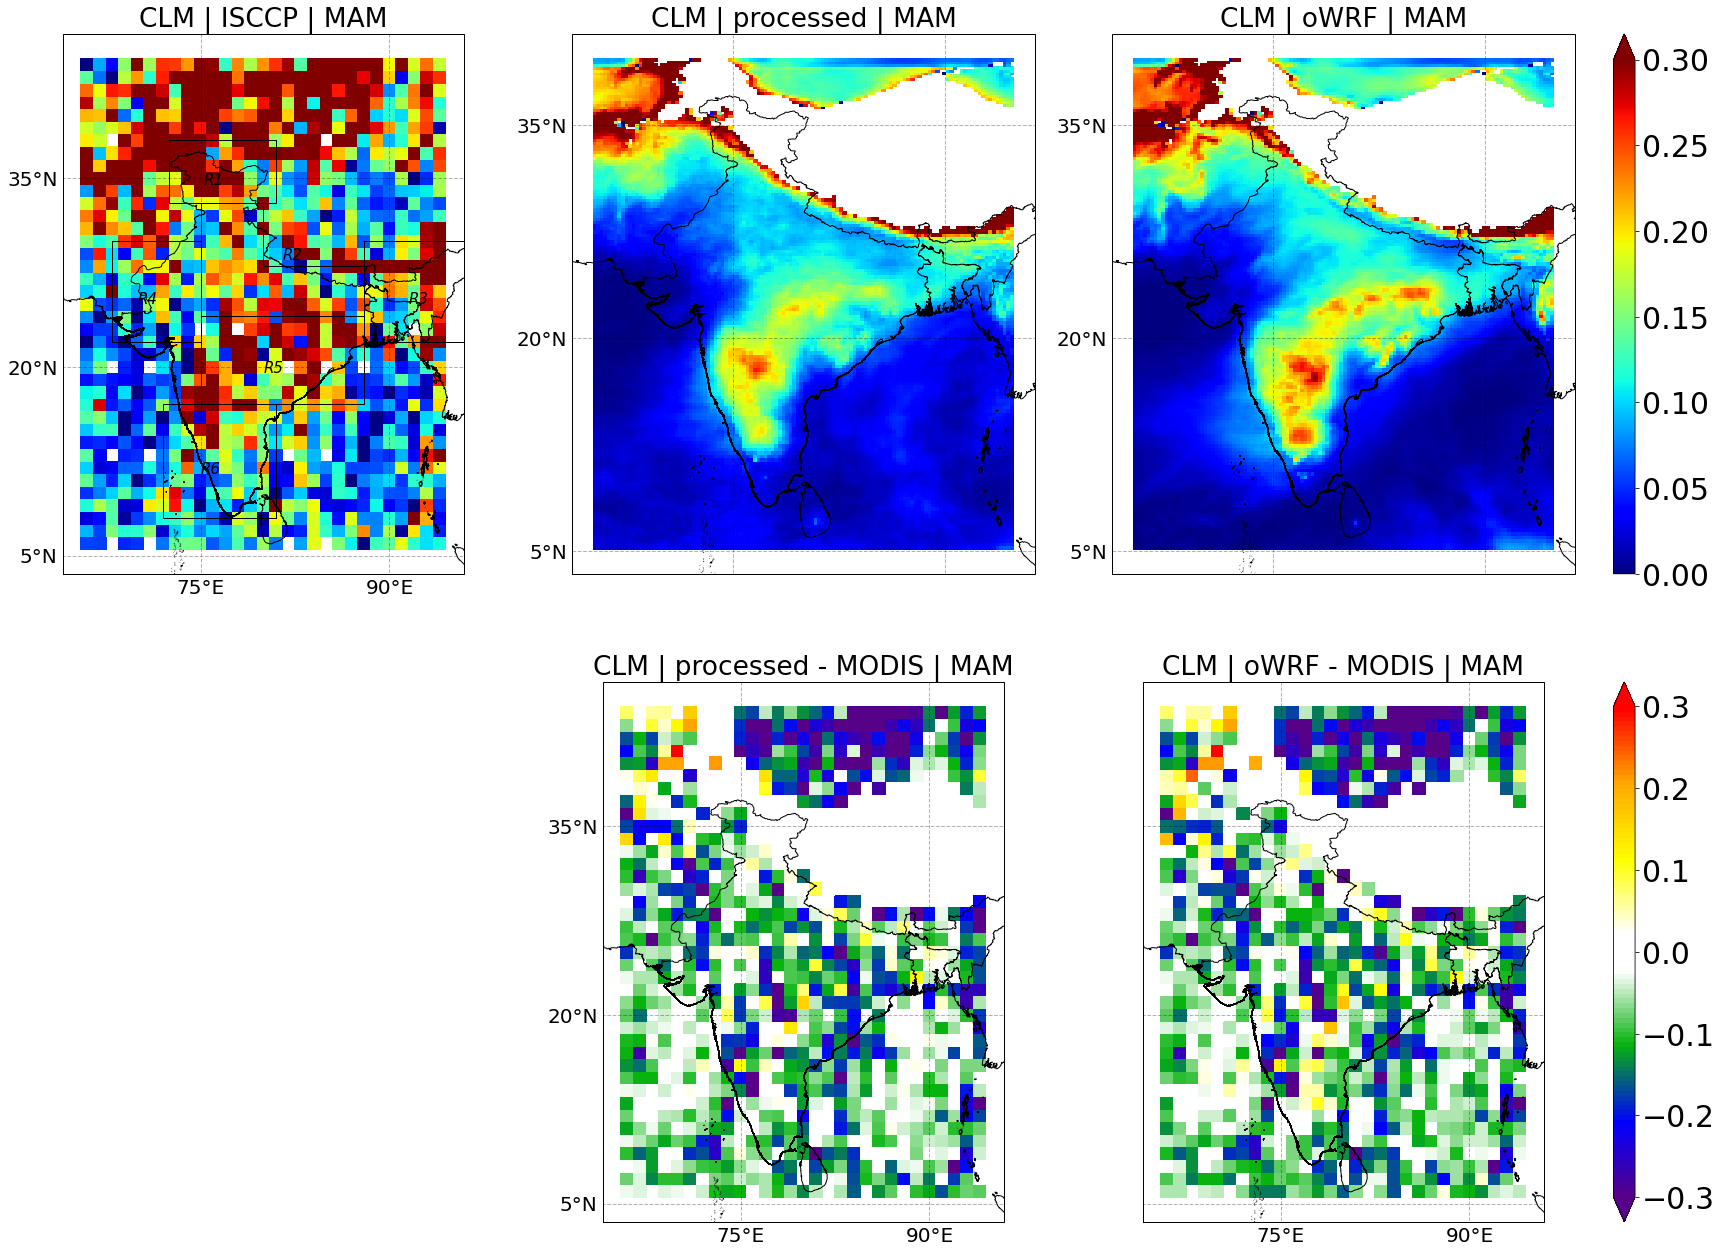

In [10]:
from dask.diagnostics import ProgressBar
import dask
for tperiod in ['DJF','MAM']:#np.linspace(1,7,1):
    print(tperiod)
    OBS_mean = regionX(timeX(dset_OBS,tperiod),'ind').mean('time').compute()
    WRF_mean = regionX(timeX(dset_WRF,tperiod),'ind').mean('time').compute()
    cart = ccrs.PlateCarree()
    resol = reg_sel()
    ran = [0,0.3]
    cmpi = plt.cm.jet
    fig = plt.figure(figsize= (15,15))
    #'''
    j=0
    stdvname = 'CLM'
    tperiod = str(tperiod) 
    title= stdvname+' | ISCCP | '+tperiod
    ax = fig.add_axes([0.1+j*0.5,0.1,0.5,0.5],projection=cart)
    ax,pmesh,gl = spatial_plot(ax,OBS_mean.lat,OBS_mean.lon,OBS_mean,cart,ran,cmpi,title)
    gl.ylabels_left = True
    ###################
    # Draw Patches
    ###################
    for reg in ['R1','R2','R3','R4','R5','R6']:
        if reg=='R2':
            ax.add_patch(mpatches.Polygon(xy=np.array([[75,75,80,80,88,88],[24,33,33,28,28,24]]).T,facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
            pos = np.array(resol[reg]).mean(axis=1)
            ax.text(pos[0],pos[1], reg, style ='italic', fontsize = 15, color ="black",transform=ccrs.PlateCarree())
        else:
            pos = np.array(resol[reg]).mean(axis=1)
            ax.add_patch(mpatches.Rectangle(xy=[resol[reg][0][0], resol[reg][1][0]], width=resol[reg][0][1]-resol[reg][0][0], height=resol[reg][1][1]-resol[reg][1][0],facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
            ax.text(pos[0]-1.5,pos[1]-1, reg, style ='italic', fontsize = 15, color ="black",transform=ccrs.PlateCarree())
    for i in range(WRF_mean.shape[0]):
        title = stdvname+' | '+str(WRF_mean[i].exp.values)+' | '+tperiod
        ax = fig.add_axes([0.1+(i+1)*0.5,0.1,0.5,0.5],projection=cart)
        ax,pmesh,gl = spatial_plot(ax,WRF_mean.lat,WRF_mean.lon,WRF_mean.isel(exp=i),cart,ran,cmpi,title)
        gl.ylabels_left = False
        gl.xlabels_bottom = False

        if j>1:
            gl.ylabels_left = False
        else:
            gl.ylabels_left = True

    cax = fig.add_axes([0.1+(i+2)*0.5,0.1,0.02,0.5])
    cbar =  plt.colorbar(pmesh,extend='max', cax=cax)
    cbar.ax.tick_params(labelsize=30)
    import cmaps
    cmpi = cmaps.ViBlGrWhYeOrRe
    WRF_interp = WRF_mean.sel(lat=OBS_mean.lat,lon=OBS_mean.lon,method='nearest')
    ran = [-0.3,0.3]
    for i in range(WRF_mean.shape[0]):
        title= stdvname+' | '+str(WRF_mean[i].exp.values)+' - MODIS | '+tperiod
        ax = fig.add_axes([0.1+(i+1)*0.5,-0.5,0.5,0.5],projection=cart)
        ax,pmesh,gl = spatial_plot(ax,OBS_mean.lat,OBS_mean.lon,WRF_interp.isel(exp=i) - OBS_mean.data,cart,ran,cmpi,title)
        if (i+1)>1:
            gl.ylabels_left = False
        else:
            gl.ylabels_left = True

    cax = fig.add_axes([0.1+(i+2)*0.5,-0.5,0.02,0.5])
    cbar =  plt.colorbar(pmesh,extend='both', cax=cax)
    cbar.ax.tick_params(labelsize=30)

    #plt.savefig('AOD_spatial_diff.png',bbox_inches='tight',dpi=100)
    #plt.clf()
    #plt.close('all')

In [12]:
vname_m = 'ttop'
vname_o = 'MODIS-CTT'
scale = 1
dmap = ['NoLBC_DU','processed']

dset_WRF = ext_WRF(vname_m)
dset_OBS = (ext_OBS()[vname_o]).resample(time = '1D').mean()
for exp in range(2):
    with pd.ExcelWriter(vname_m+'_'+dmap[exp]+'.xlsx') as writer:
        for reg in ['R1','R2','R3','R4','R5','R6','ind']:
            sts = {}
            for mon in range(1,7,1):
                x = calc_stats(dset_WRF.isel(exp=exp),dset_OBS.sel(time = dset_OBS['time.year']==2015),region=reg,tperiod=mon,obs_name=vname_o,scale=scale)
                sts[mon] = x
            sts = pd.DataFrame(sts).T
            sts.to_excel(writer,sheet_name=reg)

['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/ttop/gn/ttop_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/ttop/gn/ttop_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/ttop/gn/ttop_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/ttop/gn/ttop_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/ttop/gn/ttop_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100-201506010000.nc', '/mnt/nas/DATA/kaushik/p

/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
vname_m = 'lwp'
vname_o = 'MODIS-LWC'
scale = 1000
dmap = ['NoLBC_DU','processed']

dset_WRF = ext_WRF(vname_m)
dset_OBS = (ext_OBS()[vname_o]).resample(time = '1D').mean()
for exp in range(2):
    with pd.ExcelWriter(vname_m+'_'+dmap[exp]+'.xlsx') as writer:
        for reg in ['R1','R2','R3','R4','R5','R6','ind']:
            sts = {}
            for mon in range(1,7,1):
                x = calc_stats(dset_WRF.isel(exp=exp),dset_OBS.sel(time = dset_OBS['time.year']==2015),region=reg,tperiod=mon,obs_name=vname_o,scale=scale)
                sts[mon] = x
            sts = pd.DataFrame(sts).T
            sts.to_excel(writer,sheet_name=reg)

['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/lwp/gn/lwp_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/lwp/gn/lwp_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/lwp/gn/lwp_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/lwp/gn/lwp_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/lwp/gn/lwp_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100-201506010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_

/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
